# Методы машинного обучения – Контрольная работа №7

# Автокодировщики

Импортируем нужные на этой лабораторной работе библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import time
import sys

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow as tf

## Наборы данных MNIST и FASHION MNIST 

Используем в материалах этой лабораторной работы два набора данных:

- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [Fashion MNIST @ Zalando](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

Эти наборы легко импортируются при помощи `keras` ([```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)).

In [2]:
from keras.datasets import mnist

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = \
    mnist.load_data()

In [3]:
mnist_x_train.shape

(60000, 28, 28)

In [4]:
mnist_y_train.shape

(60000,)

In [5]:
from keras.datasets import fashion_mnist

(fashion_x_train,fashion_y_train), (fashion_x_test,fashion_y_test) = \
    fashion_mnist.load_data()

In [6]:
print(mnist_x_train.shape, mnist_x_test.shape, mnist_y_train.shape, mnist_y_test.shape)
print(fashion_x_train.shape, fashion_x_test.shape, fashion_y_train.shape, fashion_y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [7]:
np.info(mnist_y_train)

class:  ndarray
shape:  (60000,)
strides:  (1,)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x18bdf0af600
byteorder:  little
byteswap:  False
type: uint8


## Логарифмическое правдоподобие профиля

Определим размерность латентного пространства при помощи метода PCA и правдоподобия профиля. Для вычисления логарифмического правдоподобия профиля будем использовать следующую функцию:

In [8]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", RuntimeWarning)  # for some NaN values

# Function to calculate log likelihood of PCA from eigenvalues

def log_likelihood(evals):

    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2 

    return ll

Используем небольшую часть набора `MNIST` для цифры 3:

In [9]:
mnist_x_train3 = mnist_x_train[mnist_y_train == 3]  # select images of digit '3'

n_images = 1000
train_images = mnist_x_train3[0:n_images, :, :]
n_samples, n_rows, n_cols = mnist_x_train3.shape
X = np.reshape(mnist_x_train3, (n_samples, n_rows * n_cols))

X_train = X[0 : int(n_images / 2), :]  # 500 images in train set
X_test = X[int(n_images / 2) :, :]  # 500 images in test set

In [10]:
np.info(mnist_x_train3)

class:  ndarray
shape:  (6131, 28, 28)
strides:  (784, 28, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x18beb790000
byteorder:  little
byteswap:  False
type: uint8


Построим ошибку реконструкции для различного числа главных компонент: 

In [11]:
# Reconstruction error on MNIST vs number of latent dimensions used by PCA

X_rank = np.linalg.matrix_rank(X_train)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique(np.append([1, 5, 10, 20], K_linspace))

RMSE_train = np.arange(len(Ks))
RMSE_test = np.arange(len(Ks))

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train[index] = mean_squared_error(X_train, Xtrain_proj, squared=False)

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test[index] = mean_squared_error(X_test, Xtest_proj, squared=False)

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

Построим логарифмическое правдоподобие профиля для различного числа главных компонент:

In [12]:
# profile log likelihood for PCA

n_samples, n_features = X_train.shape
Kmax = min(n_samples, n_features)

pca = PCA(n_components=Kmax)
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_  # eigenvalues in descending order

ll = log_likelihood(evals)

# Fraction of variance explained

fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

Теперь выполним визуализацию ошибки реконструкции и логарифмического правдоподобия профиля для различного числа главных компонент:

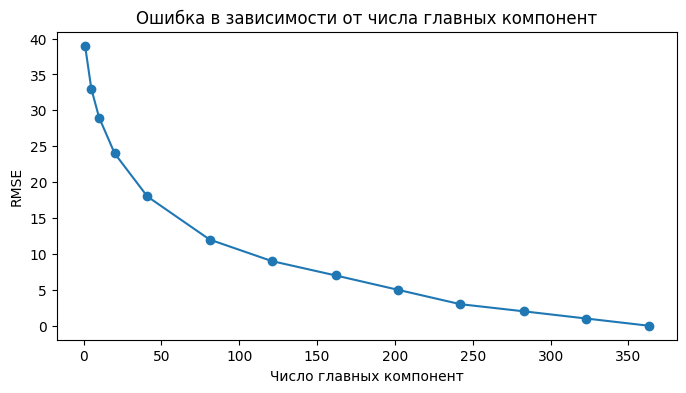

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
xs = Ks
ys = RMSE_train
plt.title("Ошибка в зависимости от числа главных компонент")
plt.xlabel("Число главных компонент")
plt.ylabel("RMSE")
ax.plot(xs, ys, marker="o")
plt.show()

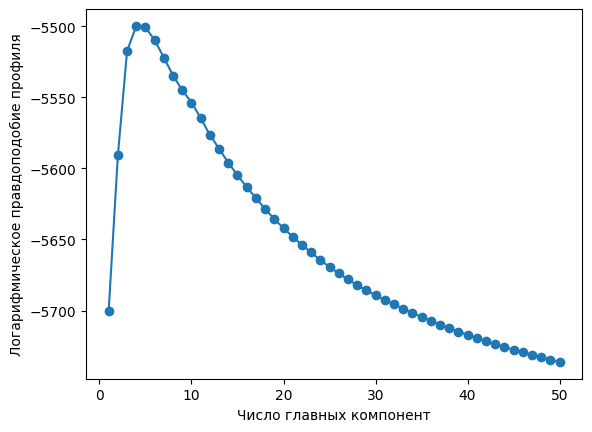

In [14]:
fig, ax = plt.subplots()
xs = np.arange(1, 51)
ys = ll[0:50]
plt.xlabel("Число главных компонент")
plt.ylabel("Логарифмическое правдоподобие профиля")

ax.plot(xs, ys, marker="o")
plt.show()

### Подготовка наборов данных для глубокого обучения

Как обычно, выполним типичную нормализацию наборов данных:

In [15]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test  = mnist_x_test.astype('float32') / 255.

fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test  = fashion_x_test.astype('float32') / 255.

Создадим варианты наборов данных для обучения сетей MLP:

In [16]:
mnist_x_train.shape, mnist_x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [17]:
mnist_x_trainMLP = mnist_x_train.reshape(
    (len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_testMLP  = mnist_x_test.reshape(
    (len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
mnist_x_trainMLP.shape, mnist_x_testMLP.shape

((60000, 784), (10000, 784))

In [18]:
fashion_x_train.shape, fashion_x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [19]:
fashion_x_trainMLP = fashion_x_train.reshape(
    (len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_testMLP  = fashion_x_test.reshape(
    (len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))
fashion_x_trainMLP.shape, fashion_x_testMLP.shape

((60000, 784), (10000, 784))

## Функция для создания автокодировщиков MLP

Автокодировщик состоит из двух частей: кодировщика (_encoder_) и декодера (_decoder_). Функция ```create_autoencoders()``` возвращает следующие объекты как отдельные модели:

- кодировщик 
- декодер
- полную модель, включающую кодировщик и декодер.

In [20]:
def create_autoencoders (feature_layer_dim = 16):
    input_img = Input(shape = (784,), name = 'Input_Layer')
    # Слой encoded имеет размерность, равную feature_layer_dim 
    # и содержит закодированные входные данные 
    encoded = Dense(feature_layer_dim, activation = 'relu', 
                    name = 'Encoded_Features')(input_img)
    decoded = Dense(784, activation = 'sigmoid', 
                    name = 'Decoded_Input')(encoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    encoded_input = Input(shape = (feature_layer_dim,))
    decoder = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder(encoded_input))

    return autoencoder, encoder, decoder

## Автокодировщик со слоями с $(784,16,784)$ нейронами

Начнем с автокодировщика, имеющего слои с размерностями $(784, 16, 784)$.




In [21]:
autoencoder16, encoder16, decoder16 = create_autoencoders(16)

In [22]:
#keras.utils.plot_model(autoencoder16, show_shapes=True)

Теперь нужно скомпилировать модель и обучить ее на данных. Для работы с автоэнкодерами достаточно простой модели **создать** $\rightarrow$ **compile** $\rightarrow$ **fit**.

In [23]:
autoencoder16.compile(optimizer='adam', loss='binary_crossentropy')

In [24]:
history = autoencoder16.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4229 - val_loss: 0.2269
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2137 - val_loss: 0.1826
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1779 - val_loss: 0.1618
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1605 - val_loss: 0.1510
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1504 - val_loss: 0.1437
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1437 - val_loss: 0.1397
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1405 - val_loss: 0.1371
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1380 - val_loss: 0.1350
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1359 - val_loss: 0.1333
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1343 - val_loss: 0.1318
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1328 - val_loss: 0.1307
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [25]:
encoded_imgs = encoder16.predict(mnist_x_testMLP)
decoded_imgs = decoder16.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


### Относительно сжатия

Поскольку мы сохранили и кодировщик, и декодер, мы можем создать закодированную версию изображений. Обратите внимание, что тип данных изображений — ```float32```. Каждый объект ```float32``` требует 4 байта. Исходные данные в ```mnist_x_test``` имеют вид ```(10000,784)```. Это означает, что пространство, необходимое для хранения этого массива, равно

$$
10000 \textrm{ изображений} \times 784 \textrm{ пикселей}\times 4 \textrm{ байт} = 29 \textrm{ Мб}
$$

Закодированные изображения требуют гораздо меньше места. На самом деле необходимый размер

$$
10000 \textrm{ изображений}\times 16 \textrm{ скрытых признаков}\times 4 \textrm{ байт} = 625 \textrm{ Кб}
$$

поэтому, если мы примем потерю качества в сжатых данных, мы получим невероятную степень сжатия около $46$. Эти размеры легко проверить, сохранив данные в файле и проверив размер файла. Обратите внимание, что размер файла будет больше, так как есть некоторая дополнительная информация, которую необходимо сохранить.

In [26]:
np.save('temp_orig', mnist_x_testMLP)
! ls -al temp_orig*

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [27]:
np.save('temp_encoded', encoded_imgs)
! ls -al temp_encoded*

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Анализ реконструированных изображений

Рассмотрим эффект от сжатия входных изображений. Наличие всего 16 нейронов в среднем слое дает следующий результат:

In [28]:
import matplotlib.pyplot as plt

def image_show(orig_imgs, dec_imgs, fname=None):
    n = 10  # кол-во изображений
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)    

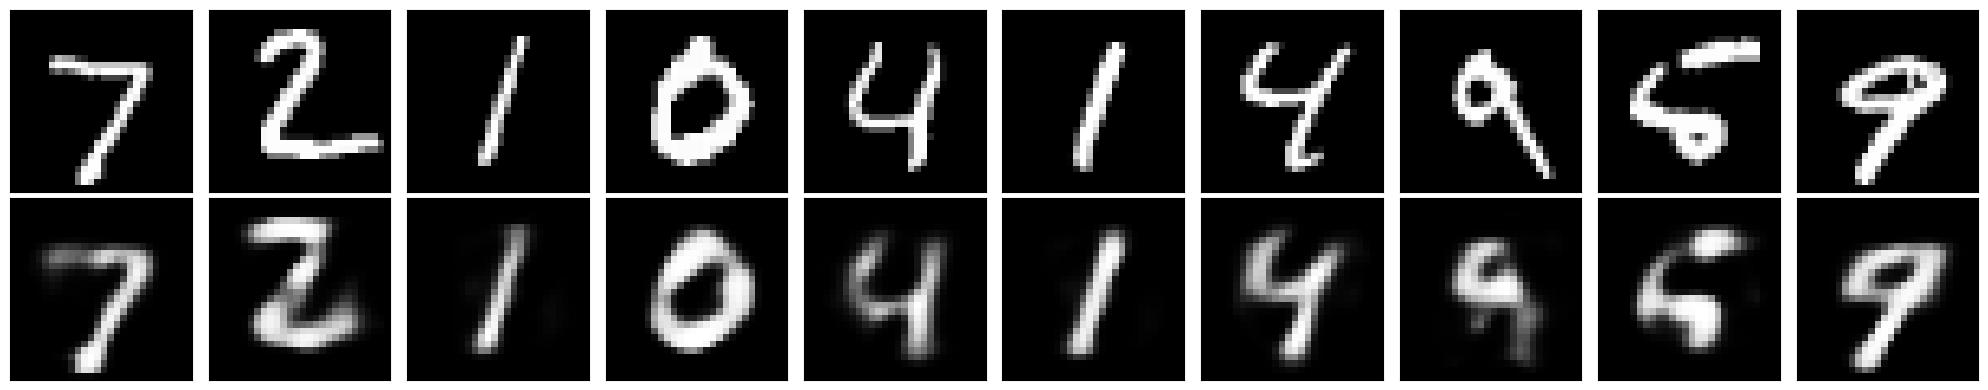

In [29]:
image_show(mnist_x_testMLP, decoded_imgs)

## Автокодировщик со слоями с $(784,64,784)$ нейронами


In [30]:
autoencoder64, encoder64, decoder64 = create_autoencoders(64)

In [31]:
autoencoder64.compile(optimizer='adam', loss='binary_crossentropy')

In [32]:
autoencoder64.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3533 - val_loss: 0.1599
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1502 - val_loss: 0.1249
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1212 - val_loss: 0.1073
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1055 - val_loss: 0.0966
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0959 - val_loss: 0.0893
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0891 - val_loss: 0.0844
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0845 - val_loss: 0.0810
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0813 - val_loss: 0.0788
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0790 - val_loss: 0.0772
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0777 - val_loss: 0.0762
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0767 - val_loss: 0.0754
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [33]:
encoded_imgs = encoder64.predict(mnist_x_testMLP)
decoded_imgs = decoder64.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


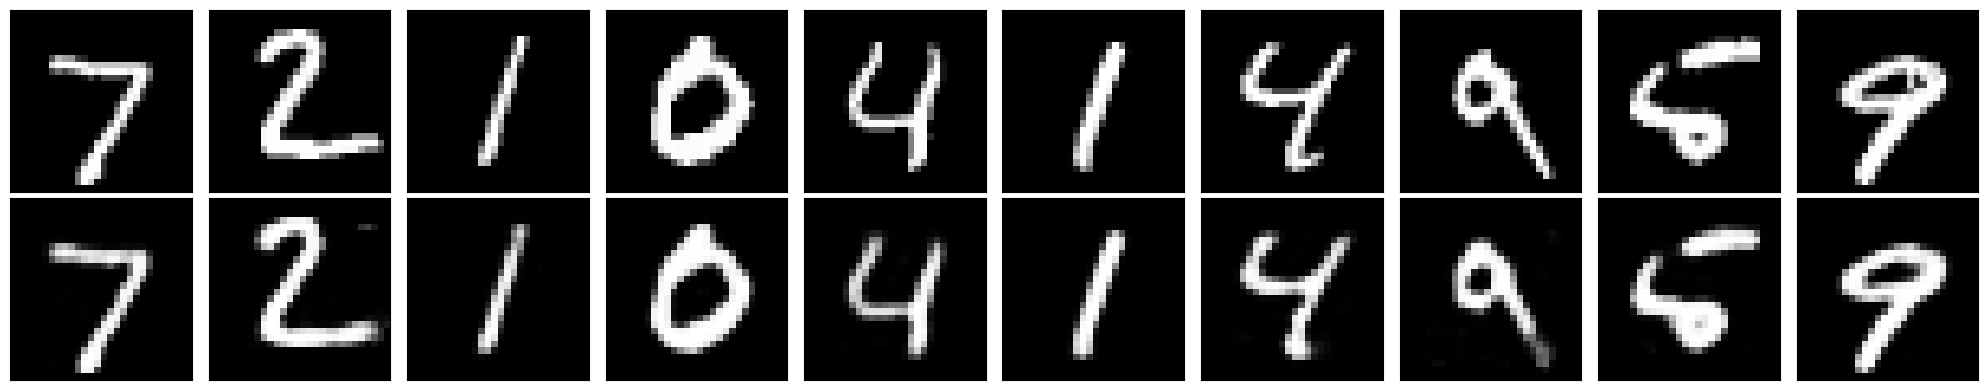

In [34]:
image_show(mnist_x_testMLP, decoded_imgs)

## Автокодировщик со слоями с $(784,8,784)$ нейронами

При уменьшении количества нейронов в среднем слое качество реконструкции существенно падает:

In [35]:
autoencoder8, encoder8, decoder8 = create_autoencoders(8)
autoencoder8.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder8.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4628 - val_loss: 0.2415
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2333 - val_loss: 0.2089
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2042 - val_loss: 0.1904
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1894 - val_loss: 0.1831
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1829 - val_loss: 0.1792
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1797 - val_loss: 0.1769
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1778 - val_loss: 0.1750
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1761 - val_loss: 0.1735
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1744 - val_loss: 0.1723
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1736 - val_loss: 0.1713
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1722 - val_loss: 0.1704
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [36]:
encoded_imgs = encoder8.predict(mnist_x_testMLP)
decoded_imgs = decoder8.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


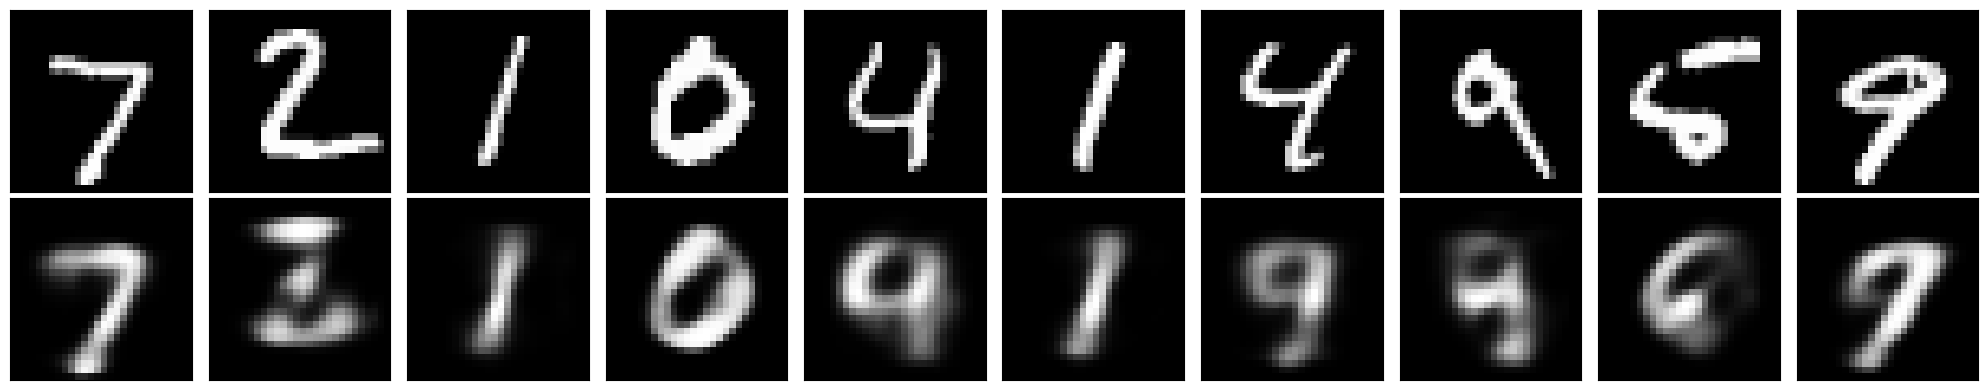

In [37]:
image_show(mnist_x_testMLP, decoded_imgs)

## Добавление ограничения разреженности

Еще один способ ограничить компактность представлений — добавить ограничение разреженности на активность скрытого представления, чтобы «срабатывало» меньшее количество нейронов. В Keras это можно сделать, добавив параметр `activity_regularizer` в плотный слой:

In [38]:
from keras import regularizers

encoding_dim = 16

input_img = Input(shape=(784,))

# плотный слой с регуляризатором активности L1 
encoded = Dense(encoding_dim, activation='relu',
    activity_regularizer=regularizers.l1(10e-5))(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

autoencoderL1 = Model(input_img, decoded)

In [39]:
autoencoderL1.compile(optimizer='adam', loss='binary_crossentropy')
autoencoderL1.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6780 - val_loss: 0.6155
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5986 - val_loss: 0.5535
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5399 - val_loss: 0.5038
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4927 - val_loss: 0.4638
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4547 - val_loss: 0.4314
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4241 - val_loss: 0.4050
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3988 - val_loss: 0.3834
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3783 - val_loss: 0.3656
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3616 - val_loss: 0.3508
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3472 - val_loss: 0.3385
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3355 - val_loss: 0.3281
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [40]:
decoded_imgs = autoencoderL1.predict(mnist_x_testMLP)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


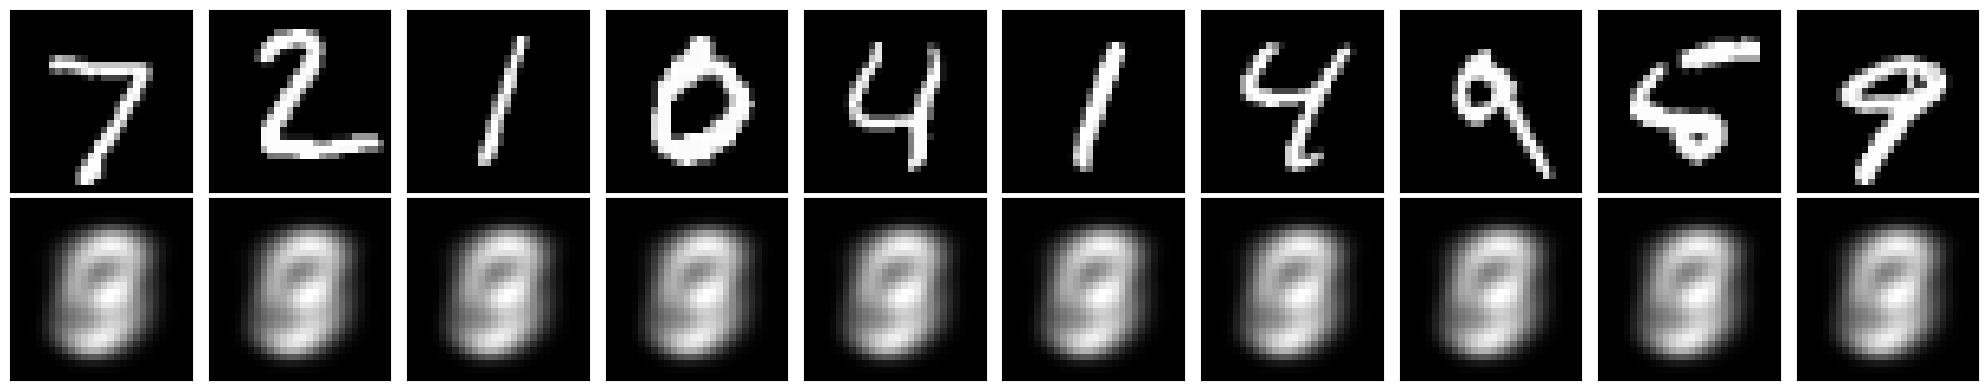

In [41]:
image_show(mnist_x_testMLP, decoded_imgs)

## Глубокий автокодировщик MLP

Вместо одного слоя в кодировщике и декодере можно использовать несколько слоев:

In [42]:
encoding_dim = 16

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoderD = Model(input_img, decoded)

In [43]:
#keras.utils.plot_model(autoencoderD, show_shapes=True)

In [44]:
autoencoderD.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderD.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3424 - val_loss: 0.1823
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1742 - val_loss: 0.1511
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1474 - val_loss: 0.1321
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1310 - val_loss: 0.1237
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1237 - val_loss: 0.1181
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1188 - val_loss: 0.1147
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1156 - val_loss: 0.1130
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1137 - val_loss: 0.1112
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1119 - val_loss: 0.1098
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1111 - val_loss: 0.1088
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1099 - val_loss: 0.1078
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

## Сверточный автокодировщик

Поскольку входными данными являются изображения, имеет смысл использовать сверточные нейронные сети в качестве кодировщиков и декодеров. На практике автокодировщики, применяемые к изображениям, всегда являются сверточными автокодировщиками — они работают намного лучше.

Кодировщик будет состоять из стека слоев `Conv2D` и `MaxPooling2D` (максимальный пул используется для пространственной понижающей дискретизации), а декодер будет состоять из стека слоев `Conv2D` и `UpSampling2D`.

In [45]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D

input_img = keras.Input(shape=(28, 28, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Здесь представление (4, 4, 8) т.е. 128-мерное

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoderCNN = Model(input_img, decoded)

In [46]:
autoencoderCNN.compile(optimizer='adam', loss='binary_crossentropy')

In [47]:
mnist_x_train.shape, mnist_x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [48]:
mnist_x_trainCNN = mnist_x_train.reshape(
    (len(mnist_x_train), 28, 28, 1))
mnist_x_testCNN  = mnist_x_test.reshape(
    (len(mnist_x_test), 28, 28, 1))
mnist_x_trainCNN.shape, mnist_x_testCNN.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [49]:
autoencoderCNN.fit(mnist_x_trainCNN, mnist_x_trainCNN,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testCNN, mnist_x_testCNN),
                verbose = 1);

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3768 - val_loss: 0.1822
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1728 - val_loss: 0.1516
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1482 - val_loss: 0.1387
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1380 - val_loss: 0.1317
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1314 - val_loss: 0.1266


In [50]:
#keras.utils.plot_model(autoencoderCNN, show_shapes=True)

In [51]:
decoded_imgs = autoencoderCNN.predict(mnist_x_testCNN)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


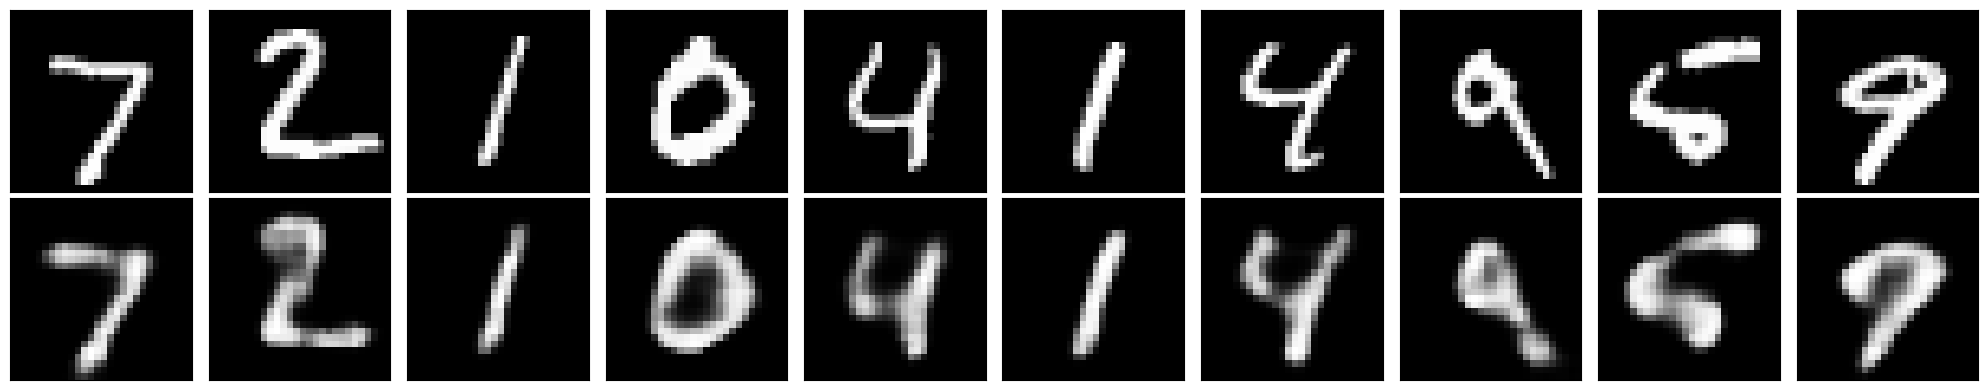

In [52]:
image_show(mnist_x_testCNN, decoded_imgs)

## Классификация по латентным признакам

Проверим, как можно использовать скрытые (латентные) признаки или, другими словами, выходные данные среднего слоя, чтобы выполнить классификацию объектов. Что происходит с точностью и производительностью алгоритмов? Проверим несколько примеров.

### Алгоритм kNN (метод ближайших соседей)

Первым протестируем алгоритм kNN из библиотеки ```sklearn```.

In [53]:
encoded_train_imgs = encoder8.predict(mnist_x_trainMLP)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step


Обратите внимание, что переменная ```encoded_train_imgs``` имеет только 8 признаков (последний обученный нами автокодировщик имел только 8 нейронов в среднем слое). В исходном наборе данных было 784 признаков (оттенки серого в пикселях изображений).

In [54]:
encoded_train_imgs.shape

(60000, 8)

In [55]:
def plot_confusion_matrix(data, labels, output_filename):
    """Визуализация матрицы ошибок при помощи heatmap
 
    Аргументы:
        data (список списков): матрица ошибок (confusion matrix)
        labels (список): Метки для осей x и y
        output_filename (текст): Путь к выходному файлу
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    sns.set(font_scale=1.3)
    ax = sns.heatmap(data, annot=True, cmap="Blues", 
                     cbar_kws={'label': 'Шкала'},fmt='d')
 
    ax.set_xticklabels(labels, fontsize = 16)
    ax.set_yticklabels(labels, fontsize = 16)
 
    ax.set_xlabel("Прогнозные метки", fontsize = 16)
    ax.set_ylabel("Истинные метки", fontsize = 16)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [56]:
# импорт необходимых библиотек 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
import seaborn as sns

Обучим классификатор на закодированных изображениях и измерим, сколько времени потребуется для обучения. Позже сделаем то же самое с исходным набором данных и сравним результаты и время выполнения.

In [57]:
start = time.time()
 
# обучаем классификатор KNN 
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=7).fit(encoded_train_imgs, 
                                              mnist_y_train) 
  
# доля верных ответов на X_test 
accuracy = knn.score(encoded_imgs, mnist_y_test) 
print (accuracy )

end = time.time()
print("Время работы",end - start,"сек.") 


0.8963
Время работы 0.6400680541992188 сек.


Всего с 8 признаками получаем 89% точности за несколько секунд.

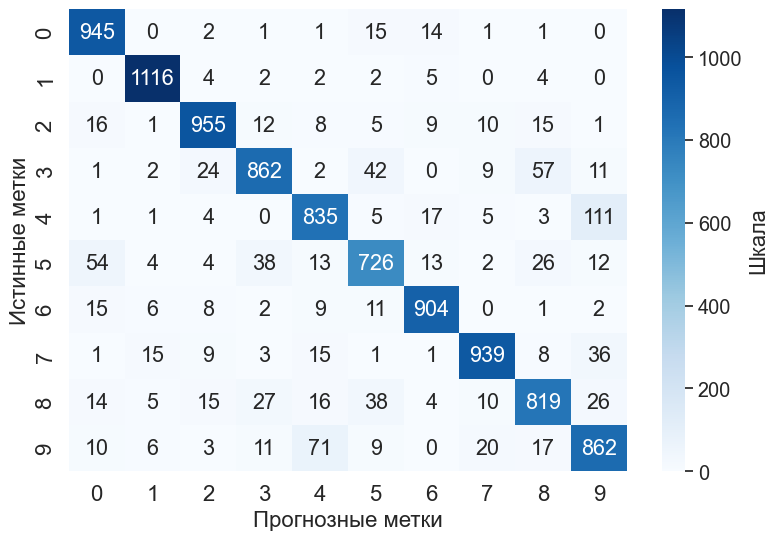

In [58]:
# строим матрицу ошибок 
knn_predictions = knn.predict(encoded_imgs)  

cm = confusion_matrix(mnist_y_test, knn_predictions)

plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9], 
                      "confusion_matrix.png")

### Алгоритм kNN со всеми признаками

Теперь давайте обучим классификатор со всеми 784 признаками.

In [59]:
start = time.time()
 
knn2 = KNeighborsClassifier(n_neighbors = 7).fit(
    mnist_x_trainMLP, mnist_y_train) 

# доля верных ответов на X_test 
accuracy = knn2.score(mnist_x_testMLP, mnist_y_test)  
print (accuracy )

end = time.time()
print("Время работы",end - start,"sec.") 

0.9694
Время работы 4.398185968399048 sec.


Со всеми признаками получаем точность 96% (на 7% больше, чем с 8 признаками), но это занимает больше времени. Для большого набора данных разница может быть гораздо более существенной.

## Функция потерь MSE

Автокодировщики настолько гибки, что работают, даже если мы используем в качестве функции потерь MSE. 

In [60]:
dim = 16

input_img = Input(shape = (784,))
encoded = Dense(dim, activation = 'relu')(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoderMSE = Model(input_img, decoded)
encoderMSE = Model(input_img, encoded)

In [61]:
encoded_input = Input(shape = (dim,))
decoder = autoencoderMSE.layers[-1]
decoderMSE = Model(encoded_input, decoder(encoded_input))

In [62]:
autoencoderMSE.compile(optimizer='adam', loss='mse')

In [63]:
autoencoderMSE.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_testMLP, mnist_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1189 - val_loss: 0.0535
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0490 - val_loss: 0.0386
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0371 - val_loss: 0.0323
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0317 - val_loss: 0.0290
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0288 - val_loss: 0.0270
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0271 - val_loss: 0.0258
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0259 - val_loss: 0.0250
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0252 - val_loss: 0.0244
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0245 - val_loss: 0.0238
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [64]:
encoded_imgs = encoderMSE.predict(mnist_x_testMLP)
decoded_imgs = decoderMSE.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


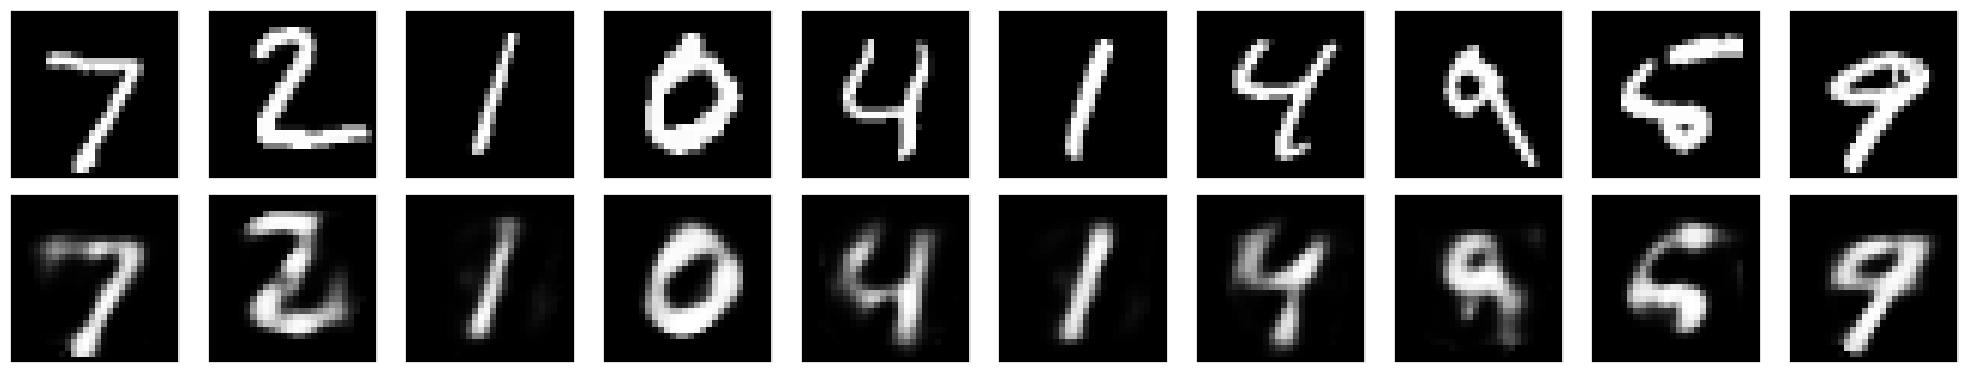

In [65]:
image_show(mnist_x_testMLP, decoded_imgs)

## Набор данных Fashion MNIST

Используем автокодировщик с 8 нейронами в среднем слое с набором данных FASHION MNIST.

In [66]:
autoencoder8, encoder8, decoder8 = create_autoencoders(8)
autoencoder8.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder8.fit(fashion_x_trainMLP, fashion_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(fashion_x_testMLP, fashion_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5469 - val_loss: 0.3815
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3690 - val_loss: 0.3499
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3445 - val_loss: 0.3383
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3341 - val_loss: 0.3321
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3287 - val_loss: 0.3283
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3263 - val_loss: 0.3253
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3231 - val_loss: 0.3229
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3206 - val_loss: 0.3210
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3192 - val_loss: 0.3196
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3160 - val_loss: 0.3185
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3171 - val_loss: 0.3177
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [67]:
encoded_imgs = encoder8.predict(fashion_x_testMLP)
decoded_imgs = decoder8.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


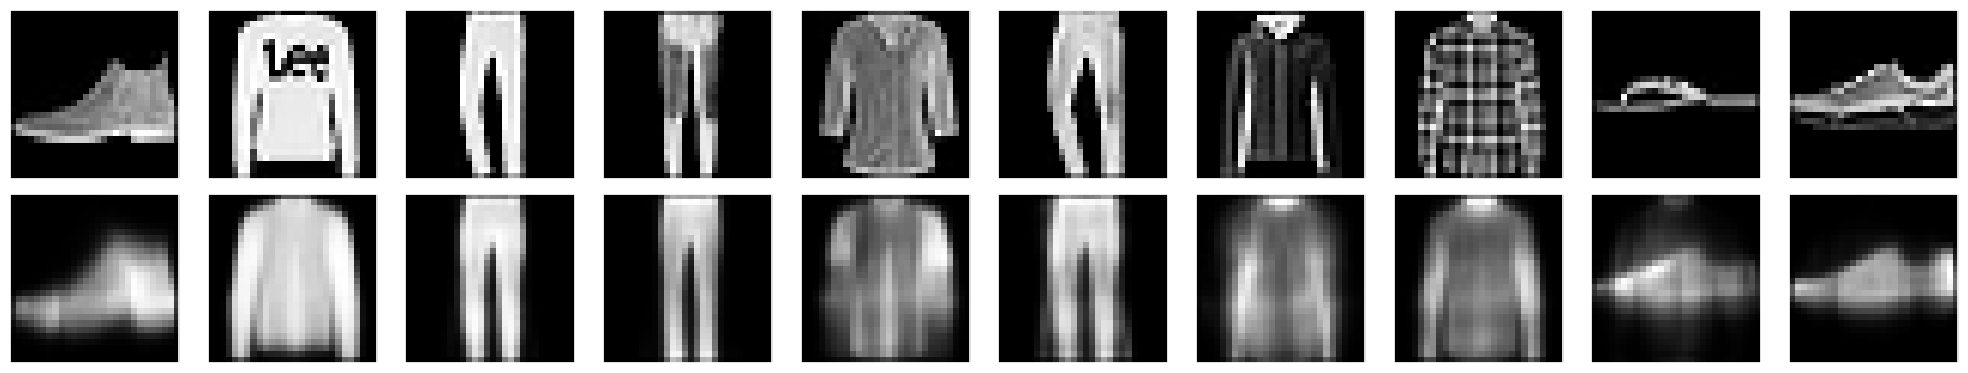

In [68]:
image_show(fashion_x_testMLP, decoded_imgs)

Снова построим классификатор со всеми данными:

In [69]:
start = time.time()

knn = KNeighborsClassifier(n_neighbors = 7).fit(
    fashion_x_trainMLP, fashion_y_train) 

# Доля верных ответов на X_test 
accuracy = knn.score(fashion_x_testMLP, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.854
3.9265670776367188


## Алгоритм kNN на обученном представлении

In [70]:
encoded_fashion_train_imgs = encoder8.predict(fashion_x_trainMLP)
encoded_fashion_test_imgs = encoder8.predict(fashion_x_testMLP)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


In [71]:
start = time.time()
 
# обучаем классификатор KNN 
knn = KNeighborsClassifier(n_neighbors = 7).fit(
    encoded_fashion_train_imgs, fashion_y_train) 
  
# доля верных ответов на X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.7949
0.33811163902282715


Опять теряем около 5% доли верных ответов за счет существенного ускорения работы. 

## Доля верных ответов для kNN с автокодировщиком с количеством нейронов $(784,16,784)$

In [72]:
autoencoder16, encoder16, decoder16 = create_autoencoders(16)
autoencoder16.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder16.fit(fashion_x_trainMLP, fashion_x_trainMLP,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(fashion_x_testMLP, fashion_x_testMLP),
                verbose = 1);

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5271 - val_loss: 0.3646
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3520 - val_loss: 0.3347
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3292 - val_loss: 0.3217
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3176 - val_loss: 0.3147
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3115 - val_loss: 0.3103
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3067 - val_loss: 0.3074
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3047 - val_loss: 0.3044
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3016 - val_loss: 0.3029
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3002 - val_loss: 0.3020
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3003 - val_loss: 0.3017
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2993 - val_loss: 0.3011
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [73]:
encoded_fashion_train_imgs = encoder16.predict(fashion_x_trainMLP)
encoded_fashion_test_imgs = encoder16.predict(fashion_x_testMLP)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


In [74]:
start = time.time()
 
# обучение классификатора KNN 
knn = KNeighborsClassifier(n_neighbors = 7).fit(
    encoded_fashion_train_imgs, fashion_y_train) 
  
# доля верных ответов на X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.8342
0.38755178451538086


Увеличение количества нейронов в среднем слое до 16 увеличивает долю верных ответов при незначительном увеличении времени работы.

## Обнаружение аномалий при помощи автокодировщиков

Разберемся, что означает обнаружение аномалий. Создадим специальный набор данных, состоящий из 10000 изображений тестового набора данных MNIST и одного изображения из набора данных Fashion MNIST. Нашей целью будет найти это изображение автоматически. 

In [75]:
x_test = np.concatenate((mnist_x_testMLP, 
                         fashion_x_testMLP[0].reshape(1,784)))
x_test.shape

(10001, 784)

Все изображения в наборе данных MNIST представляют собой написанные от руки цифры. Ниже вы можете увидеть пример одного из них.

In [76]:
def mnist_show(img):
    plt.gray()
    plt.tick_params(axis = 'x', which = 'both', bottom = False, 
                    top = False, labelbottom = False) 
    plt.tick_params(axis = 'y', which = 'both', left = False, 
                    right = False, labelleft = False)

    plt.imshow(img.reshape(28, 28))    

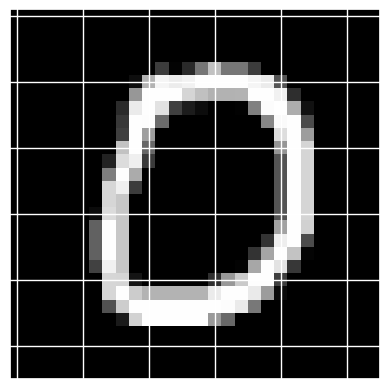

In [77]:
mnist_show(mnist_x_test[10]);

Но изображения в Fashion MNIST — это все изображения оттенками серого предметов одежды. В частности, мы добавляем к рукописным цифрам изображение обуви, которое можно увидеть ниже.

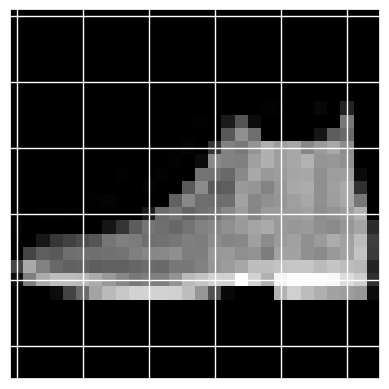

In [78]:
mnist_show(fashion_x_test[0]);

## Автокодировщик со слоями с $(784,64,784)$  нейронами

In [79]:
autoencoder64, encoder64, decoder64 = create_autoencoders(64)

In [80]:
#keras.utils.plot_model(autoencoder64, show_shapes = True)

In [81]:
autoencoder64.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [82]:
history = autoencoder64.fit(mnist_x_trainMLP, mnist_x_trainMLP,
                          epochs = 30,
                          batch_size = 256,
                          shuffle = True,
                          validation_data = (mnist_x_testMLP, mnist_x_testMLP),
                          verbose = 1)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3489 - val_loss: 0.1621
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1529 - val_loss: 0.1271
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1229 - val_loss: 0.1087
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1069 - val_loss: 0.0978
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0969 - val_loss: 0.0902
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0898 - val_loss: 0.0850
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0849 - val_loss: 0.0814
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0816 - val_loss: 0.0789
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0793 - val_loss: 0.0773
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0777 - val_loss: 0.0761
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0767 - val_loss: 0.0754
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [83]:
encoded_imgs = encoder64.predict(x_test)
decoded_imgs = decoder64.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


Теперь мы можем рассчитать ошибку реконструкции ($\textrm{RE}^{[j]}$) изображения $j$, просто вычислив

$$
\textrm{RE}^{[j]} = \sum_{i=1}^{784}\frac{(x_i^{[j]}-x_{rec,i}^{[j]})^2}{m}
$$

где $x_i^{[j]}$ — это значение $i^{го}$ пикселя изображения $j$, а сумма вычисляется по всем пикселям.

In [84]:
RE = ((x_test - decoded_imgs)**2).mean(axis = 1)
RE_original = RE.copy()

Ошибка реконструкции $\textrm{RE}$ для изображения обуви, которое мы добавили, может быть легко выведена, так как это последний элемент вектора ```RE```.

In [85]:
RE[-1]

0.06378297

Легко видеть, что это самая высокая ошибка реконструкции $\textrm{RE}$, которая у нас есть для всех 10000 изображений. Мы можем проверить это, отсортировав вектор ```RE```.

In [86]:
RE.shape

(10001,)

In [87]:
RE.sort()
print(RE[9990:])

[0.01758327 0.01762308 0.01774704 0.01777237 0.01824769 0.01872839
 0.01874767 0.01961441 0.01979768 0.02125205 0.06378297]


Вы можете видеть, что вторая по величине ошибка реконструкции составляет менее половины $\textrm{RE}$ для добавленного изображения. Ниже вы можете увидеть исходное изображение и то, которое реконструировал обученный автокодировщик. Вы можете видеть, что восстановленное изображение совсем не похоже на оригинал.

### Самая большая ошибка реконструкции RE

In [88]:
biggest_re_pos = np.argmax(RE_original)

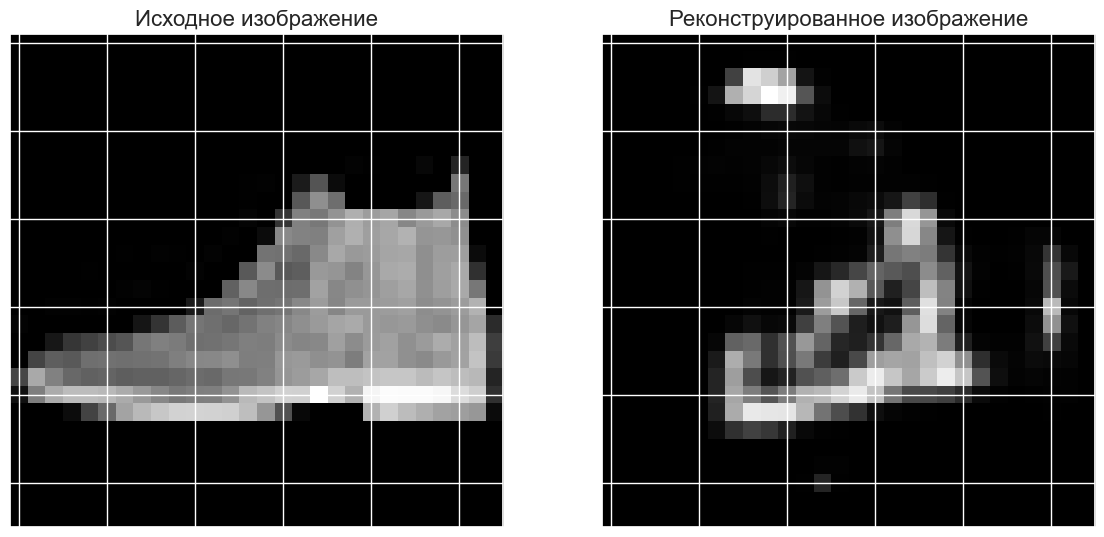

In [89]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
mnist_show(x_test[biggest_re_pos])

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
mnist_show(decoded_imgs[biggest_re_pos]);

Как вы можете видеть ниже, автокодировщик способен идеально реконструировать рукописные изображения цифр.

### Вторая по величине ошибка реконструкции RE

Изображение, показанное ниже (и его реконструированная версия), имеет вторую по величине ошибку реконструкции. Причина ясна, это изображение совсем не похоже на рукописную цифру! Это может даже считаться выбросом в наборе данных.

In [90]:
second_biggest_re_pos = list(RE_original).index(RE[-2])

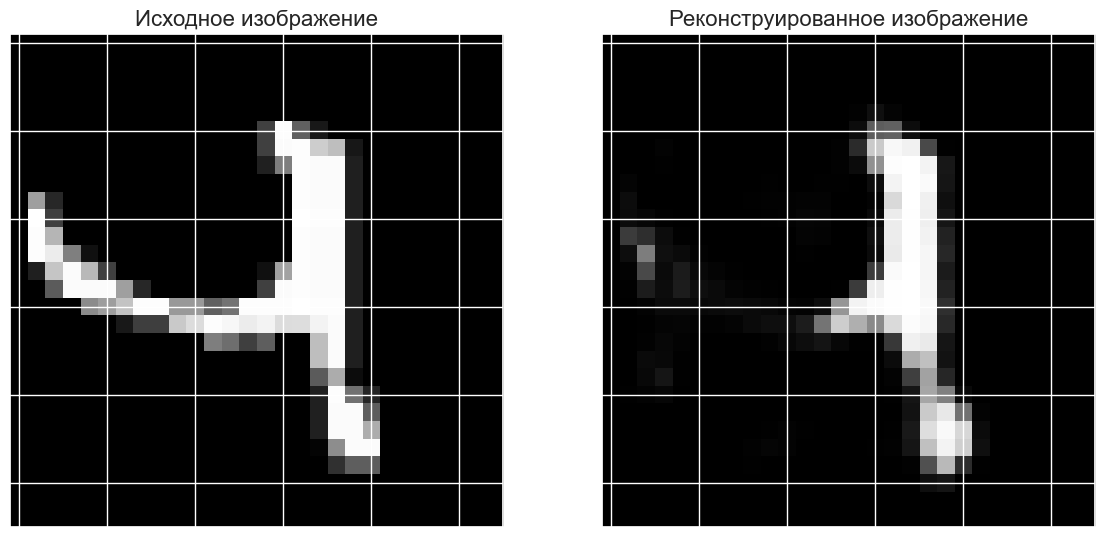

In [91]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
mnist_show(x_test[second_biggest_re_pos])

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
mnist_show(decoded_imgs[second_biggest_re_pos]);

### Третья по величине ошибка реконструкции RE

In [92]:
third_biggest_re_pos = list(RE_original).index(RE[-3])

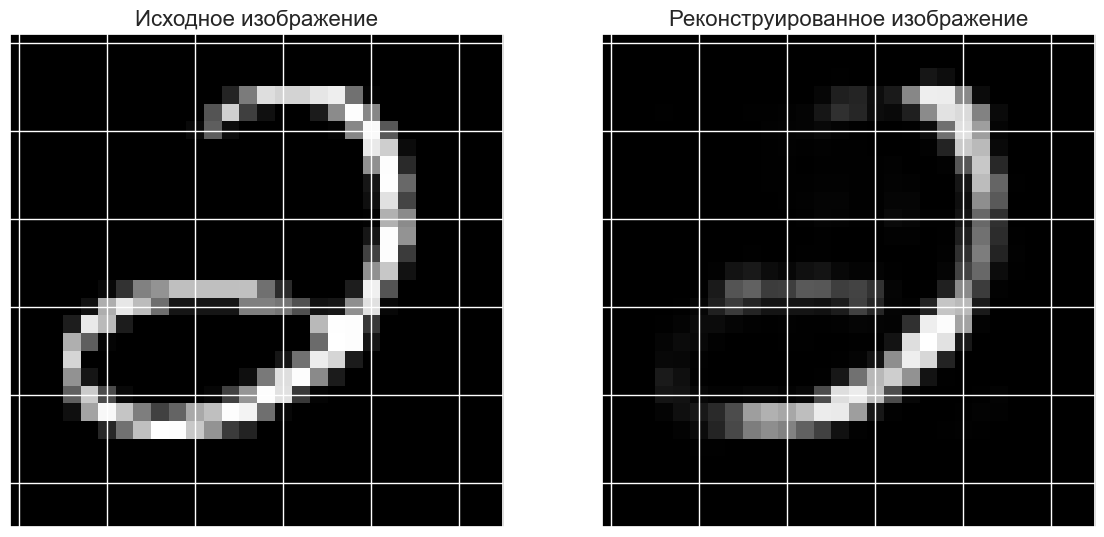

In [93]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
mnist_show(x_test[third_biggest_re_pos])

ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
mnist_show(decoded_imgs[third_biggest_re_pos]);

## Подавление шумов изображений с помощью автокодировщиков на основе нейронных сетей MLP

Используем [набор данных MNIST](http://yann.lecun.com/exdb/mnist/). Импортируем его из `keras` при помощи [```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [94]:
# Загружаем набор данных MNIST
(input_train, target_train), (input_test, target_test) = \
    mnist.load_data()

Выполним типовую нормализацию:

In [95]:
# Переводим числа в тип float32
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Нормализуем данные
input_train = input_train / 255.
input_test = input_test / 255.

In [96]:
# Изменим форму для сетей MLP
input_trainMLP = input_train.reshape(
    (len(input_train), np.prod(input_train.shape[1:])))
input_testMLP = input_test.reshape(
    (len(input_test), np.prod(input_test.shape[1:])))

In [97]:
# Изменим форму для сетей CNN
img_width, img_height = 28, 28

input_trainCNN = input_train.reshape(
    input_train.shape[0], img_width, img_height, 1)
input_testCNN = input_test.reshape(
    input_test.shape[0], img_width, img_height, 1)
input_shapeCNN = (img_width, img_height, 1)

Построим пример изображения для каждого возможного класса (то есть цифр от 0 до 9).

In [98]:
from random import *

def get_random_element_with_label (data, lbls, lbl):
    """Возвращает массив numpy (с одним столбцом) 
    с экземплярами выбранной метки."""

    tmp = lbls == lbl
    subset = data[tmp.flatten(), :]
    return subset[randint(0, subset.shape[0]), :]

In [99]:
# Изменяем форму обучающего набора данных
input_example = input_train.reshape(60000, 784)

In [100]:
# Следующий код создает массив numpy, где в столбце 0 будет
# пример метки 0, в столбце 1 метки 1 и так далее.
labels_overview = np.empty([784, 10])
for i in range (0, 10):
    col = get_random_element_with_label(
        input_example, target_train, i)
    labels_overview[:,i] = col

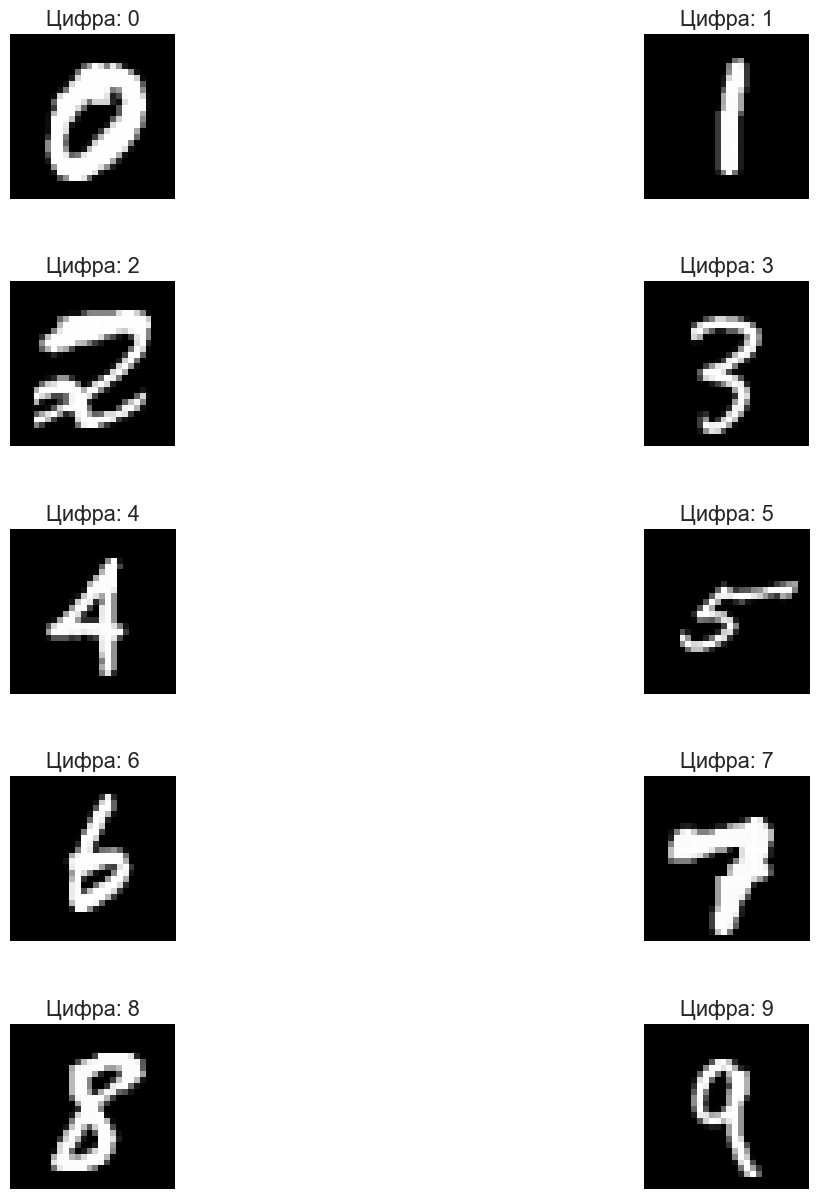

In [101]:
f = plt.figure(figsize = (15, 15))
count = 1
for i in range(0, 10):
    plt.gray()
    plt.subplot(5, 2, count)
    count = count + 1
    plt.subplots_adjust(hspace = 0.5)
    plt.title('Цифра: ' + str(i))
    some_digit_image = labels_overview[:, i]
    plt.imshow(some_digit_image.reshape(28, 28))
    plt.axis('off')
    pass

## Добавление шума в набор данных

Добавим источник шума к изображениям MNIST (с помощью функции `np.random.normal`), так как нашей целью будет удалить из них этот шум.

In [102]:
noise_factor = 0.55
pure = input_trainMLP
pure_test = input_testMLP
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

Теперь нарисуем несколько примеров изображений, искаженных шумом (по одному для каждого класса).

In [103]:
# Следующий код создает массив numpy, где в столбце 0 будет
# пример метки 0, в столбце 1 метки 1 и так далее.
labels_overview = np.empty([784, 10])
for i in range (0, 10):
    col = get_random_element_with_label(
        noisy_input, target_train, i)
    labels_overview[:,i] = col

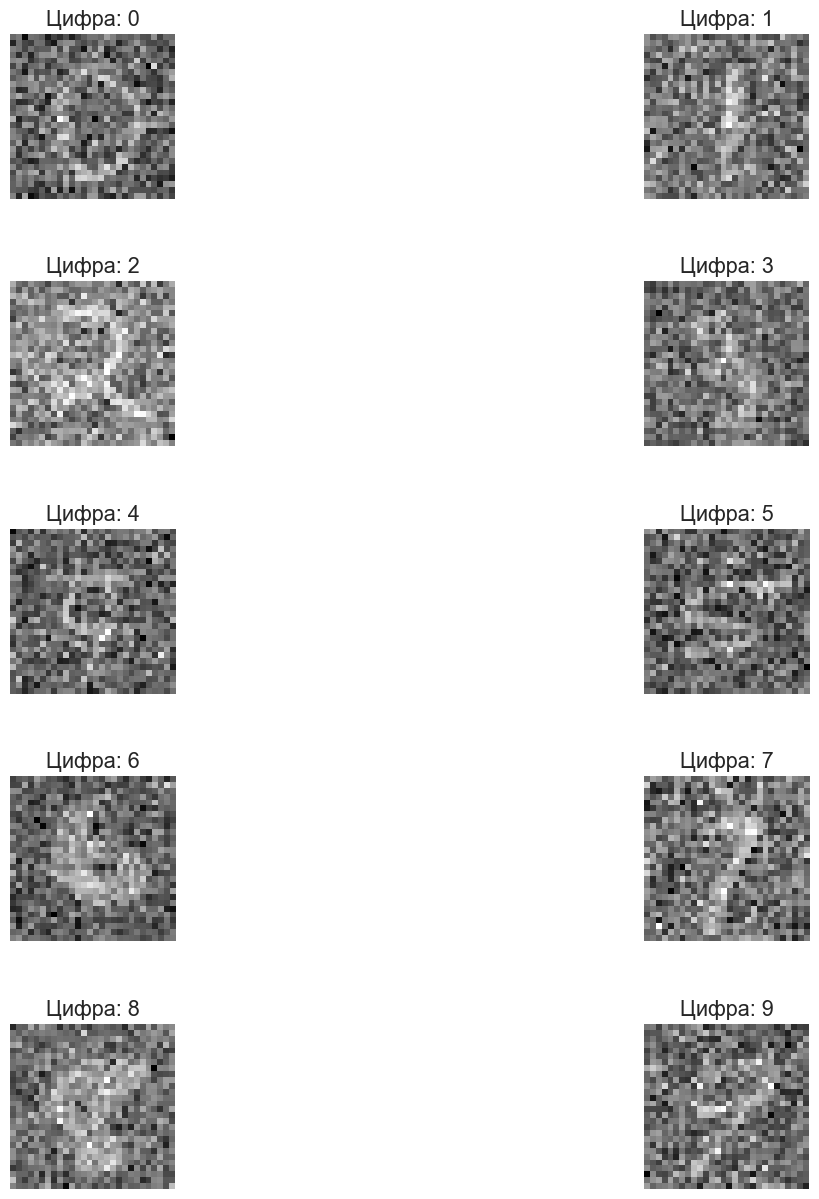

In [104]:
f = plt.figure(figsize = (15, 15))
count = 1
for i in range(0, 10):
    plt.gray()
    plt.subplot(5, 2, count)
    count = count + 1
    plt.subplots_adjust(hspace = 0.5)
    plt.title('Цифра: ' + str(i))
    some_digit_image = labels_overview[:, i]
    plt.imshow(some_digit_image.reshape(28, 28))
    plt.axis('off')
    pass

## Автокодировщик на базе сетей MLP

In [105]:
autoencoder32, encoder32, decoder32 = create_autoencoders(32) 

In [106]:
autoencoder32.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoded_Features (Dense)             │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoded_Input (Dense)                │ (None, 784)                 │          25,872 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
#keras.utils.plot_model(autoencoder32, show_shapes = True)

Воспользуемся следующими параметрами для обучения модели:

In [108]:
batch_size = 150
no_epochs = 30
validation_split = 0.2

In [109]:
autoencoder32.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder32.fit(noisy_input, pure,
                epochs = no_epochs,
                batch_size = batch_size,
                validation_split = validation_split);

Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3622 - val_loss: 0.1937
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1851 - val_loss: 0.1648
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1604 - val_loss: 0.1512
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1480 - val_loss: 0.1433
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1405 - val_loss: 0.1385
Epoch 6/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1356 - val_loss: 0.1353
Epoch 7/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1328 - val_loss: 0.1335
Epoch 8/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1312 - val_loss: 0.1324
Epoch 9/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1301 - val_loss: 0.1318
Epoch 10/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1294 - val_loss: 0.1313
Epoch 11/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1289 - val_loss: 0.1311
Epoch 12/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

## Примеры изображений с подавленным шумом

Построим несколько примеров изображений с подавленным шумом, сравнивая их с исходными чистыми изображениями, чтобы увидеть, насколько хорошо работает встроенный автокодировщик.

In [110]:
# Построим изображения без шума
number_of_visualizations = 6
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = autoencoder32.predict(samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 640x480 with 0 Axes>

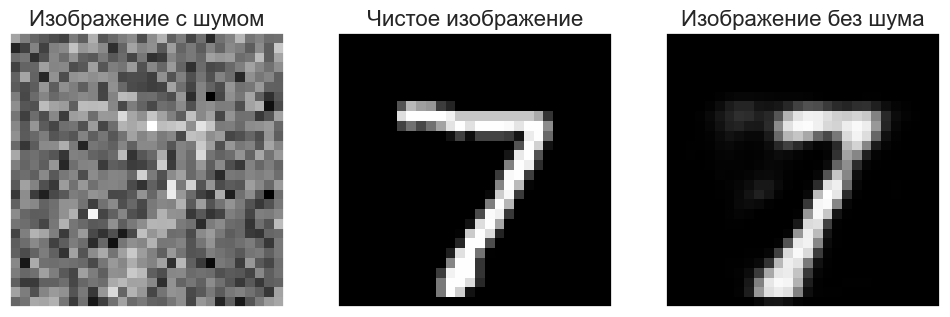

<Figure size 640x480 with 0 Axes>

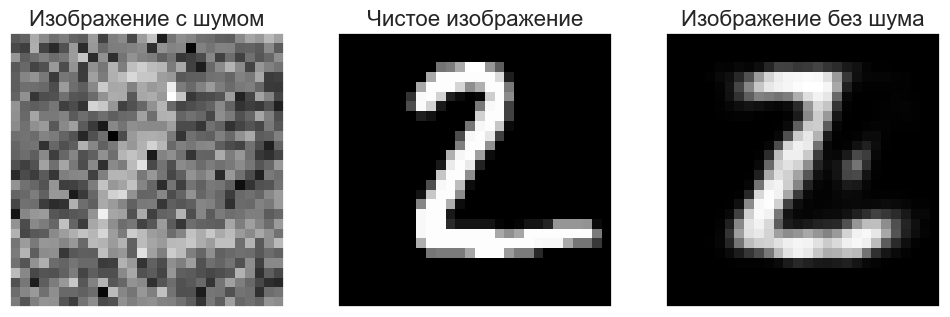

<Figure size 640x480 with 0 Axes>

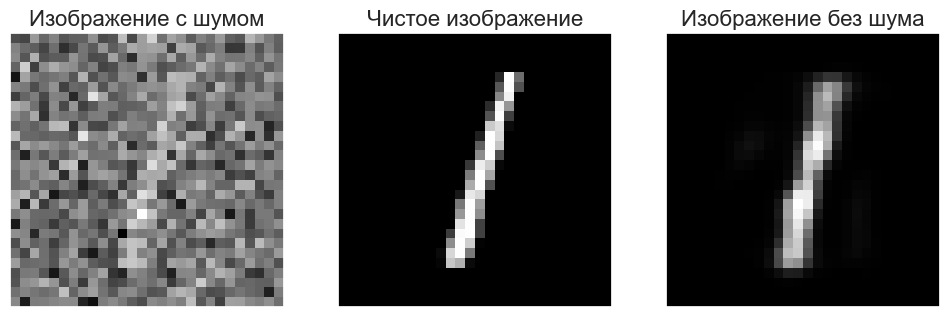

<Figure size 640x480 with 0 Axes>

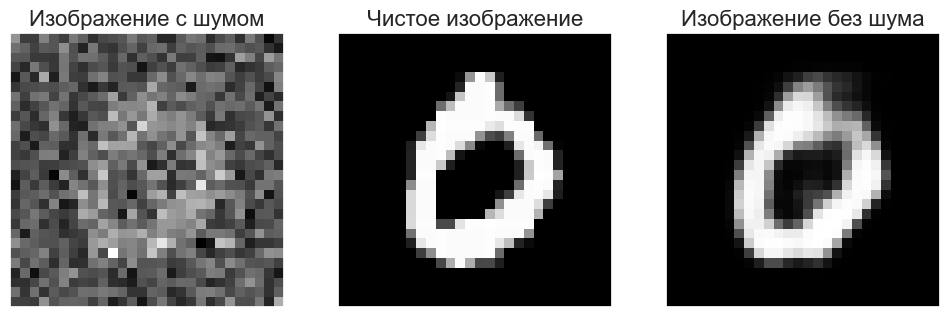

<Figure size 640x480 with 0 Axes>

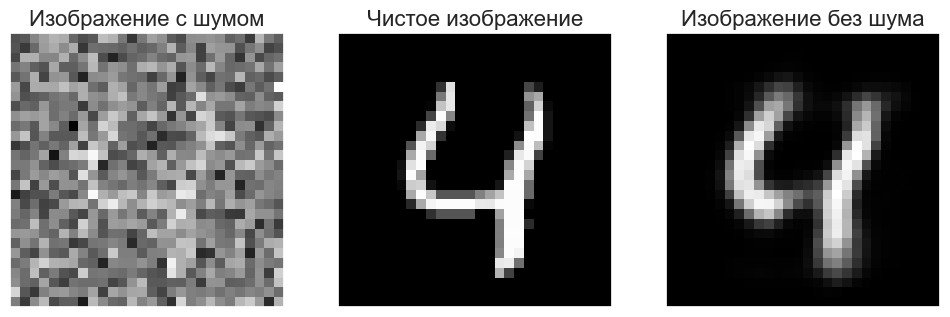

<Figure size 640x480 with 0 Axes>

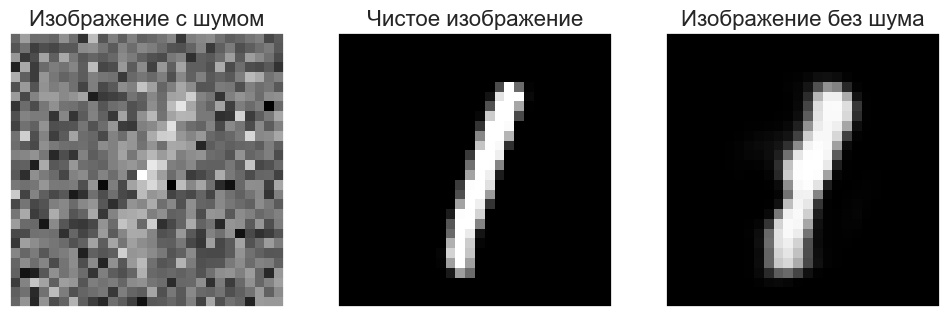

In [111]:
# нарисуем изображения без шума
for i in range(0, number_of_visualizations):
    plt.gray()
    # изображение и реконструкция
    noisy_image = noisy_input_test[i].reshape(28, 28)
    pure_image  = pure_test[i].reshape(28, 28)
    denoised_image = denoised_images[i].reshape(28, 28)
    input_class = targets[i]
    # подготовка
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(12, 7)
    # выводим изображение и реконструкцию
    axes[0].imshow(noisy_image)
    axes[0].set_title('Изображение с шумом', fontsize = 16)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(pure_image)
    axes[1].set_title('Чистое изображение', fontsize = 16)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[2].imshow(denoised_image)
    axes[2].set_title('Изображение без шума', fontsize = 16)
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    plt.show()

Как видно из приведенного выше рисунка, построенная нами модель может реконструировать исходную версию изображений зашумленных цифр. Если у вас есть новые зашумленные изображения того же типа, вы можете применить к ним модель и удалить шум с тех же изображений.

## Автокодировщик с нейронной сетью CNN 

Функция ```create_autoencoder_CNN()``` ниже возвращает модель автокодировщика на базе CNN.

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.constraints import max_norm

def create_autoencoder_CNN(max_norm_value = 2.0):
    # Создаем модель
    model = Sequential()
    model.add(Conv2D(64, kernel_size = (3, 3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform', 
                     input_shape = input_shapeCNN))
    model.add(Conv2D(32, kernel_size = (3, 3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform'))
    model.add(Conv2DTranspose(32, kernel_size = (3,3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform'))
    model.add(Conv2DTranspose(64, kernel_size = (3,3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'relu', 
                     kernel_initializer = 'he_uniform'))
    model.add(Conv2D(1, kernel_size = (3, 3), 
                     kernel_constraint = max_norm(max_norm_value), 
                     activation = 'sigmoid', padding = 'same'))
    return model

In [113]:
model = create_autoencoder_CNN()

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [114]:
#keras.utils.plot_model(model, show_shapes = True)

Для сети CNN нужна другая форма входных данных:

In [115]:
noisy_input = noisy_input.reshape(
    noisy_input.shape[0], img_width, img_height, 1)
pure = pure.reshape(
    pure.shape[0], img_width, img_height, 1)

noisy_input.shape,pure.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

Используем следующие параметры для обучения модели:

In [116]:
batch_size = 150
no_epochs = 5
validation_split = 0.2

In [117]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.fit(noisy_input, pure,
          epochs = no_epochs,
          batch_size = batch_size,
          validation_split = validation_split);

Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.1672 - val_loss: 0.1072
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.1053 - val_loss: 0.1032
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.1017 - val_loss: 0.1017
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.1003 - val_loss: 0.1007
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.0997 - val_loss: 0.1000


## Примеры изображений с подавленным шумом

Построим несколько примеров изображений с подавленным шумом, сравнивая их с исходными чистыми изображениями, чтобы увидеть, насколько хорошо работает встроенный автокодировщик.

In [118]:
noisy_input_test = noisy_input_test.reshape(
    noisy_input_test.shape[0], img_width, img_height, 1)
pure_test = pure_test.reshape(
    pure_test.shape[0], img_width, img_height, 1)

noisy_input_test.shape, pure_test.shape

((10000, 28, 28, 1), (10000, 28, 28, 1))

In [119]:
# Построим изображения без шума
number_of_visualizations = 6
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = model.predict(samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


<Figure size 640x480 with 0 Axes>

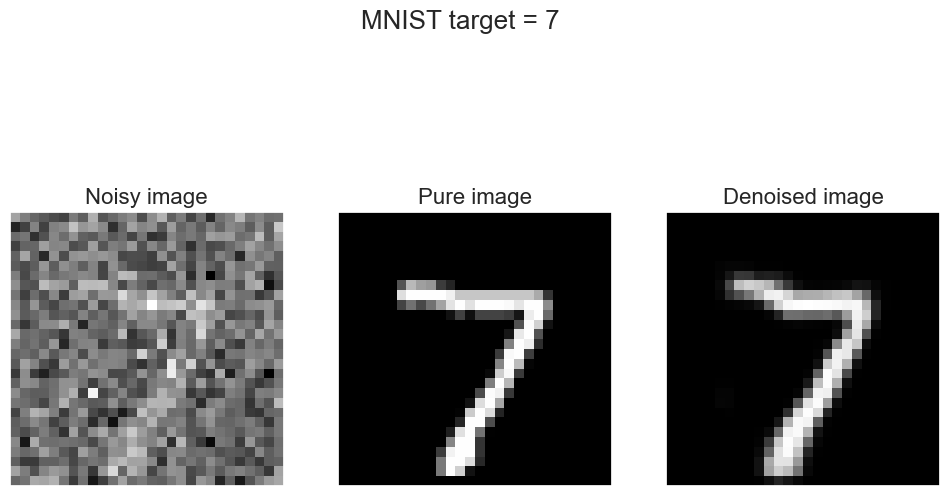

<Figure size 640x480 with 0 Axes>

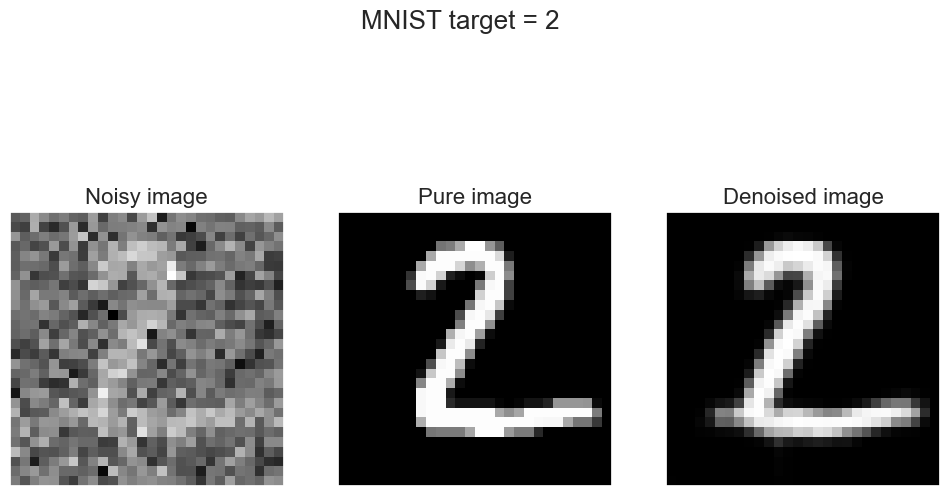

<Figure size 640x480 with 0 Axes>

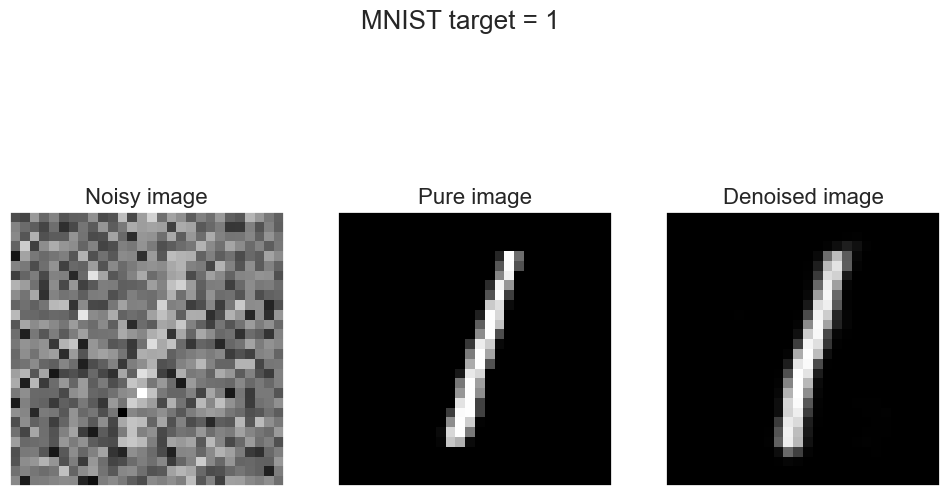

<Figure size 640x480 with 0 Axes>

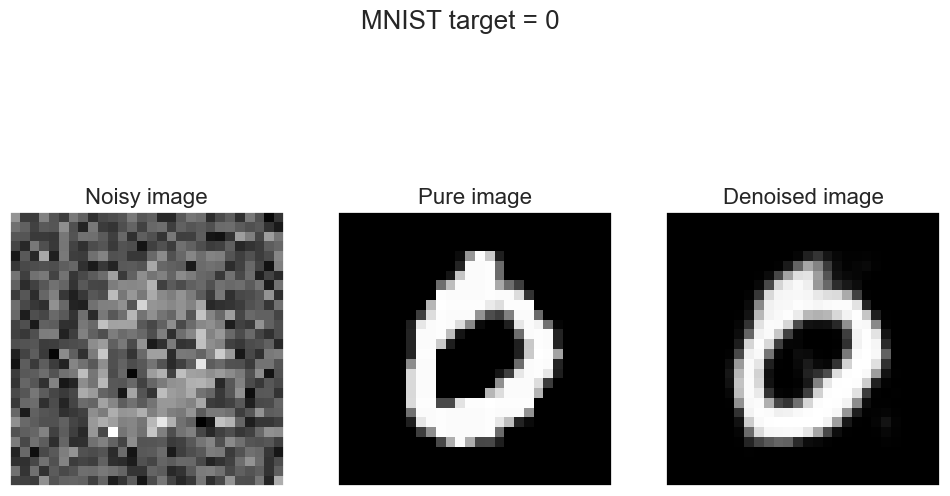

<Figure size 640x480 with 0 Axes>

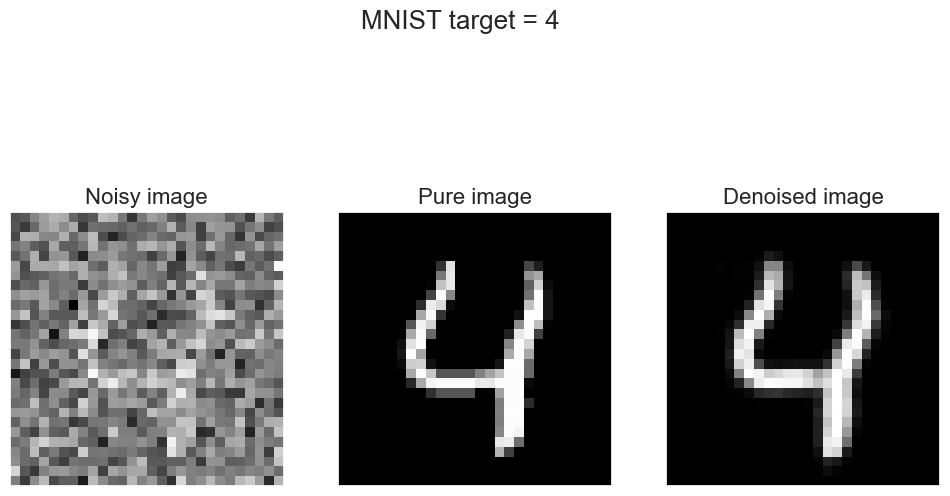

<Figure size 640x480 with 0 Axes>

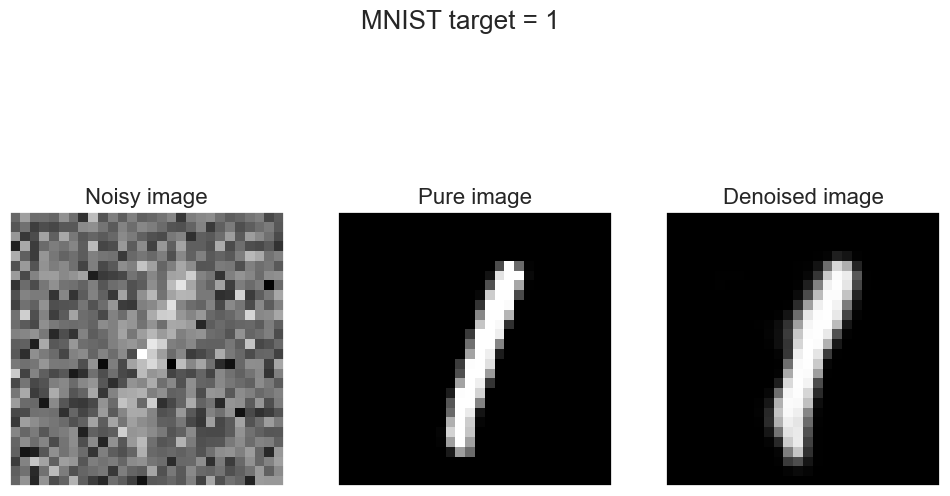

In [120]:
for i in range(0, number_of_visualizations):
    plt.gray()
    
    noisy_image = noisy_input_test[i][:, :, 0]
    pure_image  = pure_test[i][:, :, 0]
    denoised_image = denoised_images[i][:, :, 0]
    input_class = targets[i]
    
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(12, 7)
    
    axes[0].imshow(noisy_image)
    axes[0].set_title('Noisy image', fontsize = 16)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(pure_image)
    axes[1].set_title('Pure image', fontsize = 16)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[2].imshow(denoised_image)
    axes[2].set_title('Denoised image', fontsize = 16)
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    fig.suptitle(f'MNIST target = {input_class}')
    plt.show();

Как видно из приведенного выше рисунка, построенная нами модель может реконструировать исходную версию изображений зашумленных цифр. Если у вас есть новые зашумленные изображения того же типа, вы можете применить к ним модель и удалить шум с тех же изображений.

#### Задание (10 баллов)

Для закрепленного за Вами варианта работы:

1.	Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).
2.	Постройте для набора данных график логарифмического правдоподобия профиля в зависимости от числа главных компонент и определите размерность латентного пространства.
3.	Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании, с размерностью скрытого представления, равной размерности латентного пространства, определенной в п.2. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений. 
4.	Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.
5.	Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.
6.	Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените долю верных ответов (accuracy) для двух построенных классификаторов
7.	Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).
8.	Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения). 
9.	Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения. 

